<a href="https://colab.research.google.com/github/akkySrivastava/ai-ml-exercises/blob/main/Stock_Price_Prediction_LSTM_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
import keras
from joblib import dump, load


In this notebook, we will use LSTM to predict stock price (more precisely, we are interested in the rise and fall of a stock price based on previous information) in Keras. I will also use more than one feature in my model, and it could be interesting for you to see how we can create the LSTM input data shape required by Keras in this case.

Moreover, we are going to implement a manual Grid Search to tune the hyperparameters. We will also take advantage of Early Stopping and Callback to reduce the hyperparameter tunning time. To the best of my knowledge, the tunned model has the best result on this data in the Kaggle.

In [40]:
# df = pd.read_csv('https://drive.google.com/file/d/1y8l2quW5xqQZGNdznnvS8Byse9WJwNms/view?usp=sharing')
!gdown 1y8l2quW5xqQZGNdznnvS8Byse9WJwNms

df = pd.read_csv('/content/bank_nifty.csv')
df.head()

Downloading...
From: https://drive.google.com/uc?id=1y8l2quW5xqQZGNdznnvS8Byse9WJwNms
To: /content/bank_nifty.csv
100% 36.5M/36.5M [00:00<00:00, 215MB/s]


,date,open,high,low,close,symbol,timestamp
0,01-01-2019,27231.40,27236.45,27172.50,27183.45,NIFTY BANK,01-01-2019 09:15
1,01-01-2019,27181.15,27195.20,27176.45,27179.05,NIFTY BANK,01-01-2019 09:16
2,01-01-2019,27177.35,27190.30,27171.05,27190.30,NIFTY BANK,01-01-2019 09:17
3,01-01-2019,27188.65,27188.65,27150.20,27157.50,NIFTY BANK,01-01-2019 09:18
4,01-01-2019,27157.20,27161.25,27130.75,27131.30,NIFTY BANK,01-01-2019 09:19


<a id="1"></a> <br>
## Import Libraries and the Data

In [41]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random

In [42]:
def change_granularity(data_df, granularity, file_name=None, logs_coll=None):
    """Function to Change Granularity for Provided Dataframe"""
    try:
        data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], dayfirst=True)
        if 'date' in data_df.columns:
            data_df['date'] = pd.to_datetime(data_df['date'], dayfirst=True)

        if 'symbol' in data_df.columns:
            symbols = sorted(set(data_df['symbol']))
        else:
            symbols = [0]

        final_data_li = list()

        def create_row_dict(gran_calc_list):
            open_ = gran_calc_list[0]['open']
            close_ = gran_calc_list[-1]['close']
            high_ = max(gran_calc_list, key=lambda x: x['high'])['high']
            low_ = min(gran_calc_list, key=lambda x: x['low'])['low']
            timestamp_ = gran_calc_list[0]['timestamp']

            row_dict = {'open': open_, 'high': high_, 'low': low_, 'close': close_,
                        'timestamp': timestamp_}

            if 'oi' in gran_calc_list[-1]:
                row_dict['oi'] = gran_calc_list[-1]['oi']
            if 'volume' in gran_calc_list[-1]:
                row_dict['volume'] = gran_calc_list[-1]['volume']
            if 'previous_day_close' in gran_calc_list[0]:
                row_dict['previous_day_close'] = gran_calc_list[0]['previous_day_close']
            if 'curr_day_open' in gran_calc_list[0]:
                row_dict['curr_day_open'] = gran_calc_list[0]['curr_day_open']
            if 'symbol' in gran_calc_list[0]:
                row_dict['symbol'] = gran_calc_list[0]['symbol']
            if 'date' in gran_calc_list[0]:
                row_dict['date'] = gran_calc_list[0]['date']
            if 'underlying_stock' in gran_calc_list[0]:
                row_dict['underlying_stock'] = gran_calc_list[0]['underlying_stock']
            if 'strike' in gran_calc_list[0]:
                row_dict['strike'] = gran_calc_list[0]['strike']
            if 'option_type' in gran_calc_list[0]:
                row_dict['option_type'] = gran_calc_list[0]['option_type']
            if 'expiry' in gran_calc_list[0]:
                row_dict['expiry'] = gran_calc_list[0]['expiry']

            return row_dict

        for symbol in symbols:
            if symbol != 0:
                sym_data_df = data_df[data_df['symbol'] == symbol]
            else:
                sym_data_df = data_df

            sym_data_df.sort_values('timestamp', inplace=True)
            data_li = sym_data_df.to_dict('records')

            st_time = data_li[0]['timestamp'].time()

            gran_rows = list()
            gran_calc_list = list()

            for row in data_li:
                if row['timestamp'].time() == st_time:
                    if gran_calc_list:
                        row_dict = create_row_dict(gran_calc_list)

                        gran_rows.append(row_dict)

                    gran_calc_list = list()

                gran_calc_list.append(row)

                if len(gran_calc_list) == granularity:
                    row_dict = create_row_dict(gran_calc_list)

                    gran_rows.append(row_dict)
                    gran_calc_list = list()

            if gran_calc_list:
                row_dict = create_row_dict(gran_calc_list)

                gran_rows.append(row_dict)

            new_df = pd.DataFrame(gran_rows)

            new_df.dropna(subset=['close'], inplace=True)
            final_data_li.extend(new_df.to_dict('records'))

        final_df = pd.DataFrame(final_data_li)

    except Exception as e:
        final_df = data_df
        log_message = f"Exception in changing the granularity of provided dataframe.\nReturning the same dataframe\n{e}\n"
        # mg_insert_log(logs_coll, file_name, 'ERROR', log_message, log_traceback=''.join(tb.format_exception(None, e, e.__traceback__)))
        print(log_message)
        # exit()

    return final_df



In [43]:
data = change_granularity(df, 5)

data.head()

,open,high,low,close,timestamp,symbol,date
0,27231.4,27236.45,27130.75,27131.30,2019-01-01 09:15:00,NIFTY BANK,2019-01-01
1,27133.4,27144.45,27088.40,27096.95,2019-01-01 09:20:00,NIFTY BANK,2019-01-01
2,27097.0,27128.20,27092.95,27119.80,2019-01-01 09:25:00,NIFTY BANK,2019-01-01
3,27120.3,27123.30,27074.25,27083.80,2019-01-01 09:30:00,NIFTY BANK,2019-01-01
4,27085.3,27109.95,27077.30,27107.95,2019-01-01 09:35:00,NIFTY BANK,2019-01-01


<a id="2"></a> <br>
## Descriptive Analysis

In [44]:
data.head()

,open,high,low,close,timestamp,symbol,date
0,27231.4,27236.45,27130.75,27131.30,2019-01-01 09:15:00,NIFTY BANK,2019-01-01
1,27133.4,27144.45,27088.40,27096.95,2019-01-01 09:20:00,NIFTY BANK,2019-01-01
2,27097.0,27128.20,27092.95,27119.80,2019-01-01 09:25:00,NIFTY BANK,2019-01-01
3,27120.3,27123.30,27074.25,27083.80,2019-01-01 09:30:00,NIFTY BANK,2019-01-01
4,27085.3,27109.95,27077.30,27107.95,2019-01-01 09:35:00,NIFTY BANK,2019-01-01


In [45]:
print(data.columns)
print(data.shape)

Index(['open', 'high', 'low', 'close', 'timestamp', 'symbol', 'date'], dtype='object')
(99085, 7)


In [46]:
data.iloc[:, 2:-1].describe()

,low,close,timestamp
count,99085.000000,99085.000000,99085
mean,34954.854047,34983.430162,2021-09-03 18:51:47.952162560
min,16118.100000,16186.750000,2019-01-01 09:15:00
25%,29842.600000,29867.450000,2020-05-08 10:00:00
50%,35176.650000,35203.200000,2021-09-02 14:50:00
75%,41418.850000,41448.000000,2023-01-03 14:35:00
max,49892.600000,49947.500000,2024-05-09 15:25:00
std,7710.049183,7709.214857,NaN


In [47]:
data.set_index(["timestamp"], inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99085 entries, 2019-01-01 09:15:00 to 2024-05-09 15:25:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   open    99085 non-null  float64       
 1   high    99085 non-null  float64       
 2   low     99085 non-null  float64       
 3   close   99085 non-null  float64       
 4   symbol  99085 non-null  object        
 5   date    99085 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 5.3+ MB


<a id="24"></a> <br>
## Fearure Scaling

In [49]:
# Feature Scaling
data_prices = np.array( data["close"]).reshape(-1, 1)
sc = MinMaxScaler(feature_range=(0, 1))
data_prices_scaled = sc.fit_transform(data_prices)

# data

In [50]:
data_prices_scaled.shape

(99085, 1)

Here, at each point of the time, we will consider price and volume as our attributes in input_dim, and 25 days as our time_steps.

In [51]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])

    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))

    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]

    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [52]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_prices_scaled, n_future=1, n_past=25, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [53]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(79248, 25, 1)
(19812, 25, 1)
(79248, 1)
(19812, 1)


<a id="3"></a> <br>
## Train LSTM Model

In [54]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 25, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3281 (12.82 KB)
Trainable params: 3281 (12.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
867/867 [==============================] - 32s 32ms/step - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 3.3814e-04 - val_root_mean_squared_error: 0.0184
Epoch 2/40
867/867 [==============================] - 30s 34ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 4.8601e-05 - val_root_mean_squared_error: 0.0070
Epoch 3/40
867/867 [==============================] - 25s 29ms/step - loss: 6.5353e-04 - root_mean_squared_error: 0.0256 - val_loss: 1.6471e-04 - val_root_mean_squared_error: 0.0128
Epoch 4/40
867/867 [==============================] - 26s 31ms/step - loss: 5.0685e-04 - root_mean_squared_error: 0.0225 - val_loss: 4.6371e-04 - val_root_mean_squared_error: 0.0215
Epoch 5/40
867/867 [==============================] - 24s 28ms/step - loss: 4.6984e-04 - root_mean_squared_error: 0.0217 - val_loss: 4.4655e-04 - val_root_mean_squared_error: 0.0211
Epoch 6/40
867/867 [==============================] - 28s 32ms/step - loss: 4.6716e-04 - root_mean

In [56]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

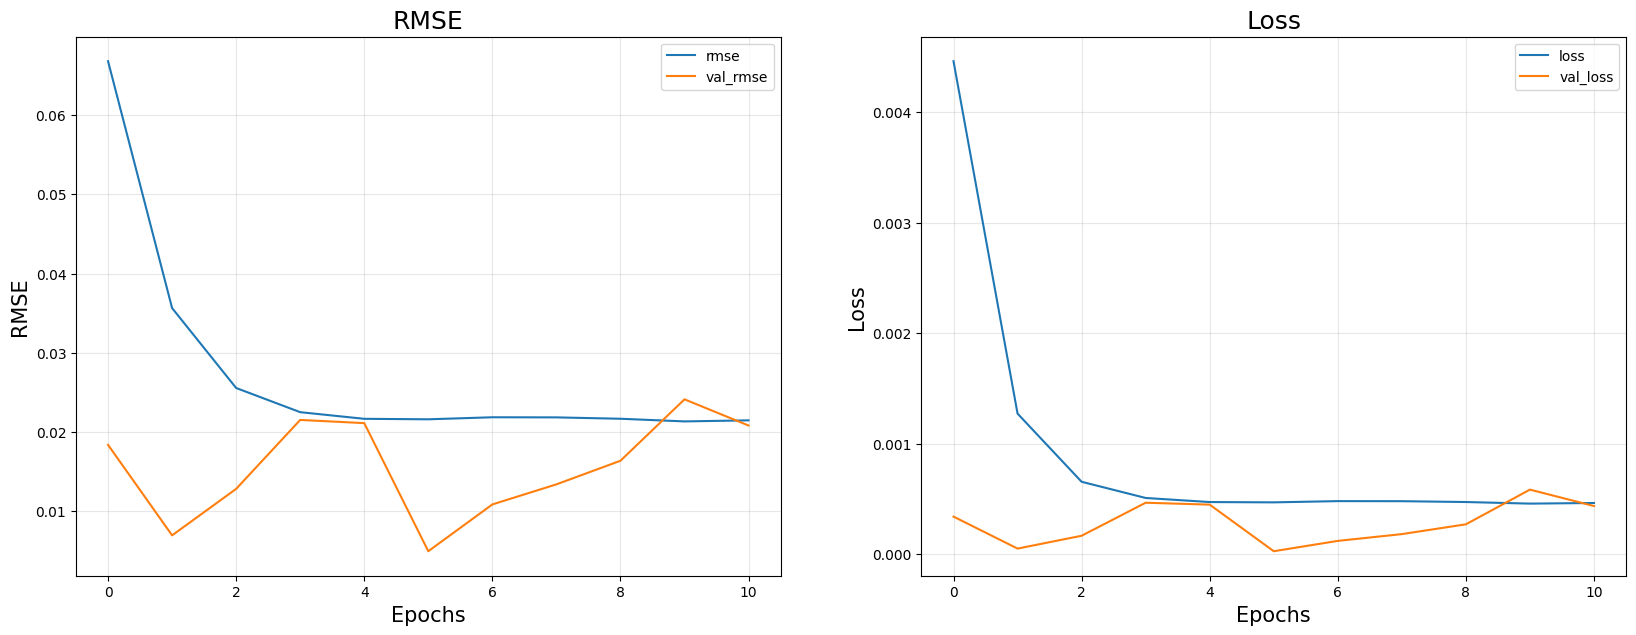

In [57]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [58]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

620/620 [==============================] - 5s 8ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473
test loss, test acc: [0.0022 0.0473]


In [59]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):

    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))

    print(possible_combinations)
    print('\n')

    hist = []

    for i in range(0, len(possible_combinations)):

        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')

        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist

In [60]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00020, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.00020 to 0.00003, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.00003

Epoch 4: val_loss improved from 0.00003 to 0.00003, saving model to best_model.h5

Epoch 5: val_loss did not improve from 0.00003

Epoch 6: val_loss did not improve from 0.00003

Epoch 7: val_loss did not improve from 0.00003

Epoch 8: val_loss did not improve from 0.00003

Epoch 9: val_loss did not improve from 0.00003
Epoch 9: early stopping
0-th combination = (False, False, False, 16, 8, 0.2) 
 train accuracy: [3.6144811019767076e-05, 0.006012055557221174] and test accuracy: [0.0008686569635756314, 0.029472986236214638]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
2th combination: 

--------------------------------------------

In [ ]:
35

<a id="44"></a> <br>
## Choosing the Best Model

In [61]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
3,False,False,False,32,8,0.2,"[2.0716572180390358e-05, 0.004551546182483435]","[0.00036000809632241726, 0.018973879516124725]"
5,False,False,False,32,32,0.2,"[3.6649526009568945e-05, 0.006053884979337454]","[0.00048681290354579687, 0.022063836455345154]"
0,False,False,False,16,8,0.2,"[3.6144811019767076e-05, 0.006012055557221174]","[0.0008686569635756314, 0.029472986236214638]"
1,False,False,False,16,16,0.2,"[0.00017335604934487492, 0.013166474178433418]","[0.0009996209992095828, 0.03161678463220596]"
4,False,False,False,32,16,0.2,"[0.00015624154184479266, 0.01249966211616993]","[0.0013304733438417315, 0.03647565469145775]"
2,False,False,False,16,32,0.2,"[0.0001715546241030097, 0.013097885996103287]","[0.00246458500623703, 0.049644585698843]"


<a id="5"></a> <br>
## Results

In [62]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')
print(f'{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 8
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0473

Results After Tunning:
 Test Set RMSE: 0.019

60.0% Improvement


In [63]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [65]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=1)

Epoch 1/40
6933/6935 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 1: val_loss improved from inf to 0.00005, saving model to best_model.h5
6935/6935 [==============================] - 191s 27ms/step - loss: 0.0010 - val_loss: 5.3616e-05
Epoch 2/40
   3/6935 [..............................] - ETA: 4:07 - loss: 3.9347e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6934/6935 [============================>.] - ETA: 0s - loss: 3.2466e-04
Epoch 2: val_loss improved from 0.00005 to 0.00002, saving model to best_model.h5
6935/6935 [==============================] - 182s 26ms/step - loss: 3.2466e-04 - val_loss: 1.5090e-05
Epoch 3/40
6934/6935 [============================>.] - ETA: 0s - loss: 3.0228e-04
Epoch 3: val_loss did not improve from 0.00002
6935/6935 [==============================] - 178s 26ms/step - loss: 3.0228e-04 - val_loss: 8.4996e-05
Epoch 4/40
6934/6935 [============================>.] - ETA: 0s - loss: 2.9380e-04
Epoch 4: val_loss did not improve from 0.00002
6935/6935 [==============================] - 183s 26ms/step - loss: 2.9380e-04 - val_loss: 3.0246e-04
Epoch 5/40
6934/6935 [============================>.] - ETA: 0s - loss: 2.8583e-04
Epoch 5: val_loss did not improve from 0.00002
6935/6935 [==============================] - 184s 26ms/step - loss: 2.8582e-04 - val_loss: 1.5878e-04
Epoch 6/40
6935/6935 [==========================

In [66]:
regressor.evaluate(X_test, y_test)

620/620 [==============================] - 5s 8ms/step - loss: 0.0010


0.0010276073589920998

620/620 [==============================] - 9s 13ms/step


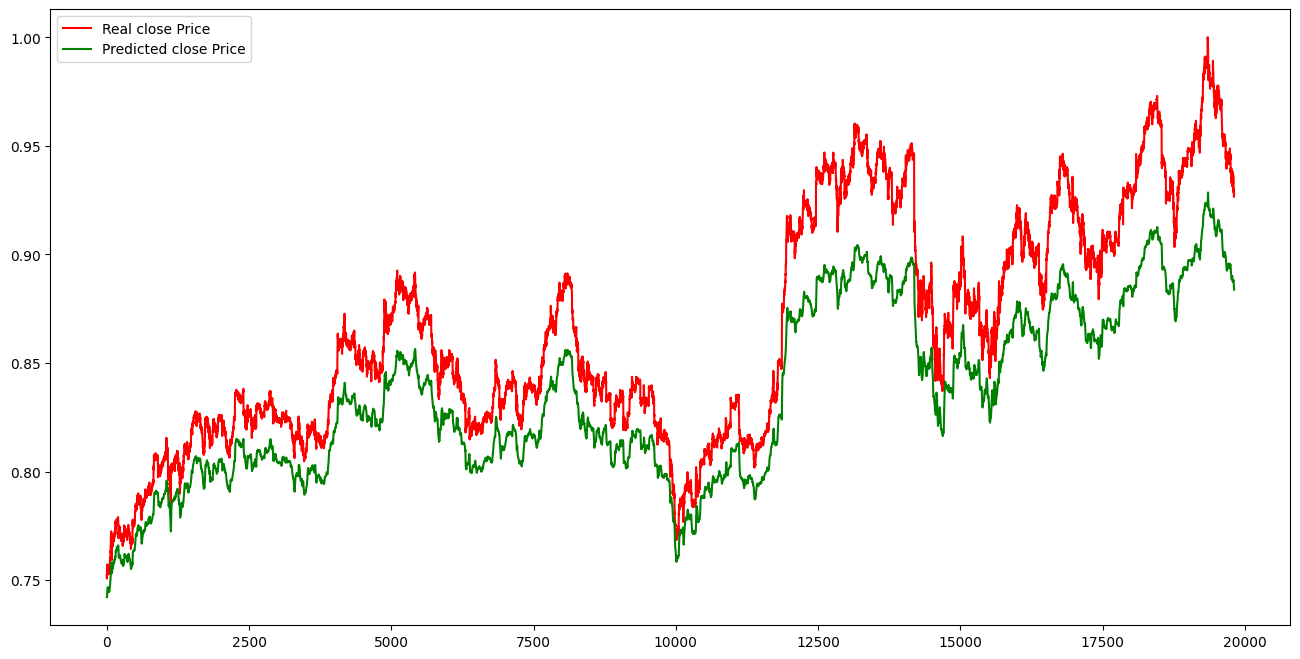

In [67]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real close Price')
plt.plot(y_pred, color='green', label = 'Predicted close Price')
plt.legend(loc='best')

In [68]:
import pickle

pickle_out = open("forecasting_model_tuned.pickle","wb")
pickle.dump(regressor, pickle_out)
pickle_out.close()

In [69]:
from google.colab import files
filename = 'forecasting_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(regressor, file)
print(f'Model saved to {filename}')

files.download(filename)

Model saved to forecasting_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>